In [29]:
import pandas as pd
from rdkit import Chem
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


In [30]:
df = pd.read_csv('../data/tox21.csv')
df

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,TOX3028,CC(O)(P(=O)(O)O)P(=O)(O)O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX2725,CCOc1nc2cccc(C(=O)O)c2n1Cc1ccc(-c2ccccc2-c2nnn...
8002,1.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,TOX2370,CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(...
8003,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX2371,C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...
8004,1.0,1.0,0.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,TOX2377,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...


In [153]:
df['NR-AR'].value_counts()

NR-AR
0.0    7123
1.0     309
Name: count, dtype: int64

### For Visualisation

In [204]:
def convert_smiles_to_mol_graph(smiles):
    # Convert SMILES to RDKit Mol object
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES: {smiles}")

    # Initialize graph
    G = nx.Graph()

    # Add atoms as nodes
    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(), element=atom.GetSymbol())

    # Add bonds as edges
    for bond in mol.GetBonds():
        start_atom = bond.GetBeginAtomIdx()
        end_atom = bond.GetEndAtomIdx()
        bond_type = bond.GetBondType()
        G.add_edge(start_atom, end_atom, bond_type=str(bond_type))

    return G

In [205]:
graph = convert_smiles_to_mol_graph('COc1ccc2c(c1OC)CN1CCc3cc4c(cc3C1C2)OCO4')

In [206]:
print(len(graph))

25


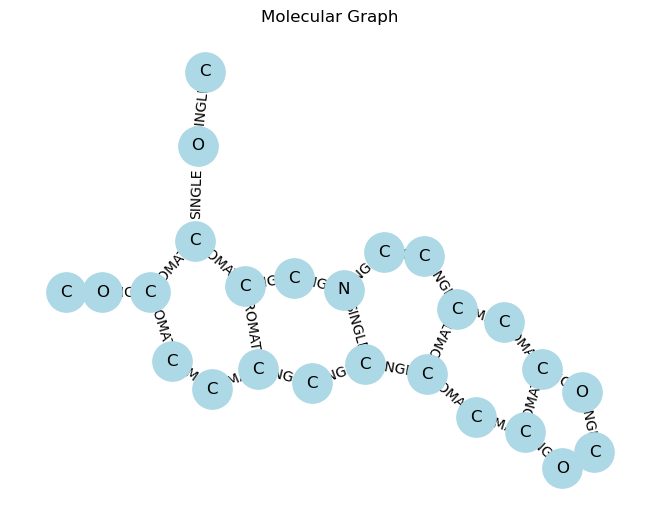

In [211]:
# Visualize the graph
pos = nx.spring_layout(graph)
labels = nx.get_node_attributes(graph, 'element')
nx.draw(graph, pos, with_labels=True, labels=labels, node_size=800, node_color="lightblue")
edge_labels = nx.get_edge_attributes(graph, 'bond_type')
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
plt.title("Molecular Graph")
plt.show()

### For Graph Neural Network

In [59]:
import numpy as np
# RDkit
from rdkit import Chem
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
# Pytorch and Pytorch Geometric
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [60]:
def one_hot_encoding(x, permitted_list):
    """
    Maps input elements x which are not in the permitted list to the last element
    of the permitted list.
    """
    if x not in permitted_list:
        x = permitted_list[-1]
    binary_encoding = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]
    return binary_encoding

In [61]:
def get_atom_features(atom, 
                      use_chirality = True, 
                      hydrogens_implicit = True):
    """
    Takes an RDKit atom object as input and gives a 1d-numpy array of atom features as output.
    """

    # define list of permitted atoms
    
    permitted_list_of_atoms =  ['C','N','O','S','F','Si','P','Cl','Br','Mg','Na','Ca','Fe','As','Al','I', 'B','V','K','Tl','Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn', 'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr','Pt','Hg','Pb','Unknown']
    
    if hydrogens_implicit == False:
        permitted_list_of_atoms = ['H'] + permitted_list_of_atoms
    
    # compute atom features
    
    atom_type_enc = one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)
    
    n_heavy_neighbors_enc = one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])
    
    formal_charge_enc = one_hot_encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, "Extreme"])
    
    hybridisation_type_enc = one_hot_encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])
    
    is_in_a_ring_enc = [int(atom.IsInRing())]
    
    is_aromatic_enc = [int(atom.GetIsAromatic())]
    
    atomic_mass_scaled = [float((atom.GetMass() - 10.812)/116.092)]
    
    vdw_radius_scaled = [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5)/0.6)]
    
    covalent_radius_scaled = [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64)/0.76)]

    atom_feature_vector = atom_type_enc + n_heavy_neighbors_enc + formal_charge_enc + hybridisation_type_enc + is_in_a_ring_enc + is_aromatic_enc + atomic_mass_scaled + vdw_radius_scaled + covalent_radius_scaled
                                    
    if use_chirality == True:
        chirality_type_enc = one_hot_encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
        atom_feature_vector += chirality_type_enc
    
    if hydrogens_implicit == True:
        n_hydrogens_enc = one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
        atom_feature_vector += n_hydrogens_enc

    return np.array(atom_feature_vector)

In [62]:
def get_bond_features(bond, 
                      use_stereochemistry = True):
    """
    Takes an RDKit bond object as input and gives a 1d-numpy array of bond features as output.
    """

    permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]

    bond_type_enc = one_hot_encoding(bond.GetBondType(), permitted_list_of_bond_types)
    
    bond_is_conj_enc = [int(bond.GetIsConjugated())]
    
    bond_is_in_ring_enc = [int(bond.IsInRing())]
    
    bond_feature_vector = bond_type_enc + bond_is_conj_enc + bond_is_in_ring_enc
    
    if use_stereochemistry == True:
        stereo_type_enc = one_hot_encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
        bond_feature_vector += stereo_type_enc

    return np.array(bond_feature_vector)

In [63]:
def create_pytorch_geometric_graph_data_list_from_smiles_and_labels(x_smiles, y):
    """
    Inputs:
    
    x_smiles = [smiles_1, smiles_2, ....] ... a list of SMILES strings
    y = [y_1, y_2, ...] ... a list of numerial labels for the SMILES strings (such as associated pKi values)
    
    Outputs:
    
    data_list = [G_1, G_2, ...] ... a list of torch_geometric.data.Data objects which represent labeled molecular graphs that can readily be used for machine learning
    
    """
    
    data_list = []
    
    for (smiles, y_val) in zip(x_smiles, y):
        
        # convert SMILES to RDKit mol object
        mol = Chem.MolFromSmiles(smiles)

        # get feature dimensions
        n_nodes = mol.GetNumAtoms()
        n_edges = 2*mol.GetNumBonds()
        unrelated_smiles = "O=O"
        unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
        n_node_features = len(get_atom_features(unrelated_mol.GetAtomWithIdx(0)))
        n_edge_features = len(get_bond_features(unrelated_mol.GetBondBetweenAtoms(0,1)))

        # construct node feature matrix X of shape (n_nodes, n_node_features)
        X = np.zeros((n_nodes, n_node_features))

        for atom in mol.GetAtoms():
            X[atom.GetIdx(), :] = get_atom_features(atom)
            
        X = torch.tensor(X, dtype = torch.float)
        
        # construct edge index array E of shape (2, n_edges)
        (rows, cols) = np.nonzero(GetAdjacencyMatrix(mol))
        torch_rows = torch.from_numpy(rows.astype(np.int64)).to(torch.long)
        torch_cols = torch.from_numpy(cols.astype(np.int64)).to(torch.long)
        E = torch.stack([torch_rows, torch_cols], dim = 0)
        
        # construct edge feature array EF of shape (n_edges, n_edge_features)
        EF = np.zeros((n_edges, n_edge_features))
        
        for (k, (i,j)) in enumerate(zip(rows, cols)):
            
            EF[k] = get_bond_features(mol.GetBondBetweenAtoms(int(i),int(j)))
        
        EF = torch.tensor(EF, dtype = torch.float)
        
        # construct label tensor
        y_tensor = torch.tensor(np.array([y_val]), dtype = torch.float)
        
        # construct Pytorch Geometric data object and append to data list
        data_list.append(Data(x = X, edge_index = E, edge_attr = EF, y = y_tensor))

    return data_list

In [196]:
graph_data = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(['COc1ccc2c(c1OC)CN1CCc3cc4c(cc3C1C2)OCO4'], [1])[0]

In [197]:
graph_data.num_node_features

79

In [212]:
# # visualise the graph 
# from torch_geometric.utils import to_networkx

# # Convert to NetworkX for visualization
# G = to_networkx(graph_data, to_undirected=True)

# # Draw the graph (node features are not shown here)
# plt.figure(figsize=(8, 6))
# nx.draw(G, with_labels=True, node_color='skyblue', edge_color='gray', node_size=800, font_size=10)
# plt.title("Molecular Graph from SMILES")
# plt.show()

In [215]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels, dropout_rate=0.3, dropout_location='none'):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)

        self.fc1 = torch.nn.Linear(hidden_channels, hidden_channels // 2)
        self.fc2 = torch.nn.Linear(hidden_channels // 2, 2)

        self.dropout_rate = dropout_rate
        self.dropout_location = dropout_location.lower()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))

        x = global_mean_pool(x, batch)
        if self.dropout_location in ['after_pool', 'both']:
            x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = self.fc1(x)
        x = F.relu(x)
        if self.dropout_location in ['after_fc1', 'both']:
            x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
# now we train the model for each of the twelve classification tasks
from sklearn.model_selection import train_test_split

# define the targets
targets = ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 
           'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 
           'SR-HSE', 'SR-MMP', 'SR-p53']

# define the number of epochs
num_epochs = 6

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(
                    num_node_features=79,
                    hidden_channels=256,
                    dropout_rate=0.2,
                    dropout_location='after_pool'
                ).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


In [273]:
y = df['NR-AR']
mask = y.notna()
x_clean = df['smiles'][mask].to_list()
y_clean = y[mask].to_list()

In [287]:
x_train, x_test, y_train, y_test = train_test_split(x_clean, y_clean, test_size=0.2, random_state=42)

# create the dataset
train_dataset = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(x_train, y_train)
test_dataset = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(x_test, y_test)

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(train_dataset)
train_dataset[0].x

[00:44:28] WARNING: not removing hydrogen atom without neighbors


[Data(x=[21, 79], edge_index=[2, 38], edge_attr=[38, 10], y=[1]), Data(x=[26, 79], edge_index=[2, 54], edge_attr=[54, 10], y=[1]), Data(x=[12, 79], edge_index=[2, 24], edge_attr=[24, 10], y=[1]), Data(x=[4, 79], edge_index=[2, 6], edge_attr=[6, 10], y=[1]), Data(x=[15, 79], edge_index=[2, 32], edge_attr=[32, 10], y=[1]), Data(x=[25, 79], edge_index=[2, 56], edge_attr=[56, 10], y=[1]), Data(x=[15, 79], edge_index=[2, 30], edge_attr=[30, 10], y=[1]), Data(x=[58, 79], edge_index=[2, 126], edge_attr=[126, 10], y=[1]), Data(x=[5, 79], edge_index=[2, 8], edge_attr=[8, 10], y=[1]), Data(x=[14, 79], edge_index=[2, 28], edge_attr=[28, 10], y=[1]), Data(x=[38, 79], edge_index=[2, 84], edge_attr=[84, 10], y=[1]), Data(x=[24, 79], edge_index=[2, 54], edge_attr=[54, 10], y=[1]), Data(x=[17, 79], edge_index=[2, 34], edge_attr=[34, 10], y=[1]), Data(x=[21, 79], edge_index=[2, 42], edge_attr=[42, 10], y=[1]), Data(x=[5, 79], edge_index=[2, 8], edge_attr=[8, 10], y=[1]), Data(x=[8, 79], edge_index=[2, 

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [288]:
print(train_dataset)
print(len(train_dataset))
print(len(test_dataset))

[Data(x=[21, 79], edge_index=[2, 38], edge_attr=[38, 10], y=[1]), Data(x=[26, 79], edge_index=[2, 54], edge_attr=[54, 10], y=[1]), Data(x=[12, 79], edge_index=[2, 24], edge_attr=[24, 10], y=[1]), Data(x=[4, 79], edge_index=[2, 6], edge_attr=[6, 10], y=[1]), Data(x=[15, 79], edge_index=[2, 32], edge_attr=[32, 10], y=[1]), Data(x=[25, 79], edge_index=[2, 56], edge_attr=[56, 10], y=[1]), Data(x=[15, 79], edge_index=[2, 30], edge_attr=[30, 10], y=[1]), Data(x=[58, 79], edge_index=[2, 126], edge_attr=[126, 10], y=[1]), Data(x=[5, 79], edge_index=[2, 8], edge_attr=[8, 10], y=[1]), Data(x=[14, 79], edge_index=[2, 28], edge_attr=[28, 10], y=[1]), Data(x=[38, 79], edge_index=[2, 84], edge_attr=[84, 10], y=[1]), Data(x=[24, 79], edge_index=[2, 54], edge_attr=[54, 10], y=[1]), Data(x=[17, 79], edge_index=[2, 34], edge_attr=[34, 10], y=[1]), Data(x=[21, 79], edge_index=[2, 42], edge_attr=[42, 10], y=[1]), Data(x=[5, 79], edge_index=[2, 8], edge_attr=[8, 10], y=[1]), Data(x=[8, 79], edge_index=[2, 

In [289]:
all_labels = [data.y.item() for data in train_dataset]
class_counts = np.bincount(all_labels)
total = sum(class_counts)
print(class_counts)
# Inverse frequency weighting
weights = total / (len(class_counts) * class_counts)
weights = torch.tensor(weights, dtype=torch.float).to(device)
weights

[5687  258]


/var/folders/5n/m32d0hsx4959r42x3mssyjj40000gn/T/ipykernel_73358/2496646491.py:2: DeprecationWarning: Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)
  class_counts = np.bincount(all_labels)


tensor([ 0.5227, 11.5213])

In [290]:
# training loop
for epoch in range(num_epochs):
    model.train()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        # print(data.y.long())
        loss = F.nll_loss(out, data.y.long())
        loss.backward()
        optimizer.step()



KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

# testing loop
model.eval()
y_true = []
y_pred = []
y_probs = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model(data)
        pred = out.argmax(dim=1).view(-1).cpu().numpy()
        prob = torch.softmax(out, dim=1)[:, 1].cpu().numpy()

        y_true.extend(data.y.view(-1).cpu().numpy())
        y_pred.extend(pred)
        y_probs.extend(prob)

accuracy = accuracy_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_probs)
print(accuracy)
print(y_true)
auc

0.9737726967047747
[np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(

np.float64(0.7850715495111694)

## Training and Validation loop to find best epoch

In [291]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

train_losses = []
val_losses = []
val_aucs = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0  # For tracking training loss
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y.long(), weight=torch.tensor([0.5, 5]).to(device))
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---- Validation per epoch ----
    model.eval()
    val_loss = 0
    y_true = []
    y_probs = []

    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            loss = F.nll_loss(out, data.y.long(), weight=torch.tensor([0.5, 5]).to(device))
            val_loss += loss.item()

            prob = torch.softmax(out, dim=1)[:, 1].cpu().numpy()
            y_true.extend(data.y.view(-1).cpu().numpy())
            y_probs.extend(prob)

    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    val_auc = roc_auc_score(y_true, y_probs)
    val_aucs.append(val_auc)

    print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val AUC: {val_auc:.4f}")


Epoch 01 | Train Loss: 0.4327 | Val Loss: 0.3796 | Val AUC: 0.7335
Epoch 02 | Train Loss: 0.4269 | Val Loss: 0.4039 | Val AUC: 0.7412
Epoch 03 | Train Loss: 0.4244 | Val Loss: 0.3913 | Val AUC: 0.7750
Epoch 04 | Train Loss: 0.4303 | Val Loss: 0.4117 | Val AUC: 0.7175
Epoch 05 | Train Loss: 0.4480 | Val Loss: 0.3774 | Val AUC: 0.7563
Epoch 06 | Train Loss: 0.4257 | Val Loss: 0.3799 | Val AUC: 0.7445
Epoch 07 | Train Loss: 0.4218 | Val Loss: 0.3799 | Val AUC: 0.7410
Epoch 08 | Train Loss: 0.4440 | Val Loss: 0.4669 | Val AUC: 0.7500
Epoch 09 | Train Loss: 0.4303 | Val Loss: 0.3815 | Val AUC: 0.7417
Epoch 10 | Train Loss: 0.4309 | Val Loss: 0.3823 | Val AUC: 0.7388
Epoch 11 | Train Loss: 0.4188 | Val Loss: 0.3770 | Val AUC: 0.7153
Epoch 12 | Train Loss: 0.4567 | Val Loss: 0.3916 | Val AUC: 0.7220
Epoch 13 | Train Loss: 0.4352 | Val Loss: 0.3833 | Val AUC: 0.7292


KeyboardInterrupt: 

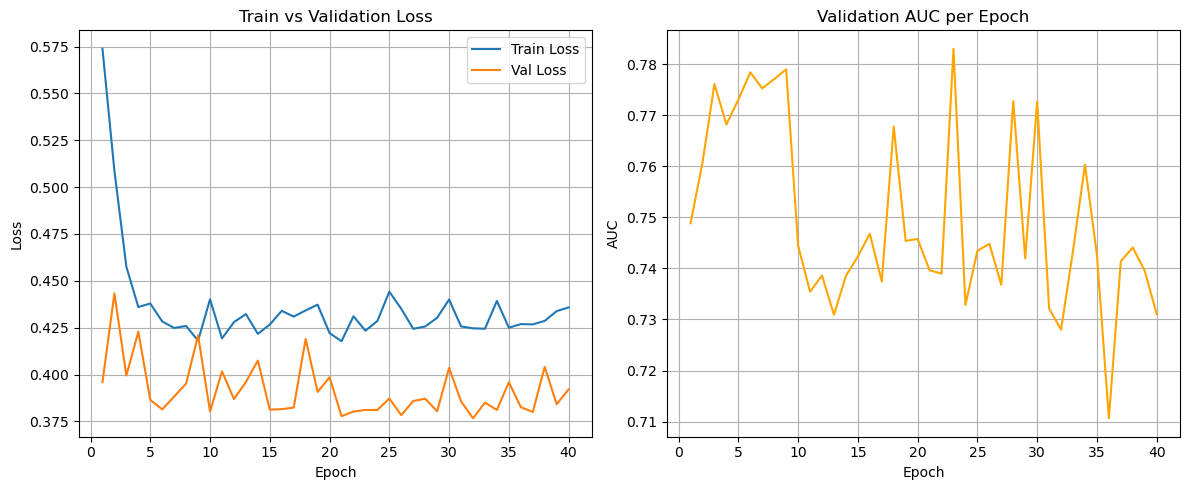

In [286]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_aucs, label="Val AUC", color='orange')
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.title("Validation AUC per Epoch")
plt.grid(True)

plt.tight_layout()
plt.show()


## Test 12 targets

In [ ]:
# for each target, we train the model, test
auc_lst = []

for target in targets:

    y = df[target]
    mask = y.notna()
    x_clean = df['smiles'][mask].to_list()
    y_clean = y[mask].to_list()
    # split the data into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(x_clean, y_clean, test_size=0.2, random_state=42)
    
    # create the dataset
    train_dataset = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(x_train, y_train)
    test_dataset = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(x_test, y_test)
    
    # create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # training loop
    for epoch in range(num_epochs):
        model.train()
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = F.nll_loss(out, data.y.long())
            loss.backward()
            optimizer.step()
    
    # testing loop
    model.eval()
    y_true = []
    # y_pred = []
    y_probs = []

    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            # pred = out.argmax(dim=1).view(-1).cpu().numpy()
            prob = torch.softmax(out, dim=1)[:, 1].cpu().numpy()

            y_true.extend(data.y.view(-1).cpu().numpy())
            # y_pred.extend(pred)
            y_probs.extend(prob)

    # accuracy = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_probs)
    auc_lst.append(auc)

print(target, auc_lst)

[15:58:38] WARNING: not removing hydrogen atom without neighbors
[15:59:24] WARNING: not removing hydrogen atom without neighbors
[16:00:03] WARNING: not removing hydrogen atom without neighbors
[16:00:37] WARNING: not removing hydrogen atom without neighbors
[16:01:12] WARNING: not removing hydrogen atom without neighbors
[16:01:43] WARNING: not removing hydrogen atom without neighbors
[16:02:23] WARNING: not removing hydrogen atom without neighbors
[16:03:32] WARNING: not removing hydrogen atom without neighbors
[16:04:13] WARNING: not removing hydrogen atom without neighbors
[16:04:47] WARNING: not removing hydrogen atom without neighbors
[16:05:23] WARNING: not removing hydrogen atom without neighbors


SR-p53 [np.float64(0.7815077284395652), np.float64(0.7662328192788654), np.float64(0.8310967807973795), np.float64(0.7419300979519146), np.float64(0.6653603464954709), np.float64(0.7423168500187394), np.float64(0.7530871634238901), np.float64(0.7499006178728818), np.float64(0.7707806112517034), np.float64(0.7272545744989833), np.float64(0.8349348406343227), np.float64(0.793389700230592)]


## Computing AUC ROC for all 12 task with 5-fold cross validation and hyperparameter tuning

In [292]:
from sklearn.model_selection import StratifiedKFold

best_results = []

hidden_channels_options = [64, 128, 256]
lr_options = [1e-3, 5e-4, 1e-4]
dropout_locations = ['none', 'after_pool', 'after_fc1']
dropout_rate_options = [0.2, 0.3]
# define the number of epochs
num_epochs = 6


In [293]:
for target in targets:
    print(f"\nProcessing target: {target}")

    # Drop NA values
    y = df[target]
    mask = y.notna()
    x_clean = df['smiles'][mask].to_list()
    y_clean = y[mask].astype(int).to_list()

    full_dataset = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(x_clean, y_clean)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    best_auc = -1
    best_config = {}

    for hidden in hidden_channels_options:
        for lr in lr_options:
            for drop_loc in dropout_locations:

                current_dropout_rates = [0.0] if drop_loc == 'none' else dropout_rate_options
                for drop_rate in current_dropout_rates:

                    auc_scores = []

                    for fold_idx, (train_idx, test_idx) in enumerate(skf.split(x_clean, y_clean)):
                        train_dataset = [full_dataset[i] for i in train_idx]
                        test_dataset = [full_dataset[i] for i in test_idx]

                        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
                        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

                        model = GCN(
                            num_node_features=79,
                            hidden_channels=hidden,
                            dropout_rate=drop_rate,
                            dropout_location=drop_loc
                        ).to(device)

                        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                        # Training
                        for epoch in range(num_epochs):
                            model.train()
                            for data in train_loader:
                                data = data.to(device)
                                optimizer.zero_grad()
                                out = model(data)
                                loss = F.nll_loss(out, data.y.long(), weight=torch.tensor([0.5, 5]).to(device))
                                loss.backward()
                                optimizer.step()

                        # Evaluation
                        model.eval()
                        y_true, y_probs = [], []

                        with torch.no_grad():
                            for data in test_loader:
                                data = data.to(device)
                                out = model(data)
                                prob = torch.softmax(out, dim=1)[:, 1].cpu().numpy()
                                y_true.extend(data.y.view(-1).cpu().numpy())
                                y_probs.extend(prob)

                        fold_auc = roc_auc_score(y_true, y_probs)
                        auc_scores.append(fold_auc)

                    avg_auc = np.mean(auc_scores)
                    std_auc = np.std(auc_scores)

                    if avg_auc > best_auc:
                        best_auc = avg_auc
                        best_config = {
                            "target": target,
                            "hidden_channels": hidden,
                            "lr": lr,
                            "dropout_location": drop_loc,
                            "dropout_rate": drop_rate,
                            "avg_auc": avg_auc,
                            "std_auc": std_auc
                        }

                    print(f"Target: {target}, Hidden: {hidden}, LR: {lr}, Dropout: {drop_loc}, Rate: {drop_rate} => Avg AUC: {avg_auc:.4f}, Std AUC: {std_auc:.4f}")

    best_results.append(best_config)
    print(f" Best for {target}: AUC={best_auc:.4f} | Config={best_config}")


Processing target: NR-AR


[00:45:35] WARNING: not removing hydrogen atom without neighbors


Target: NR-AR, Hidden: 64, LR: 0.001, Dropout: none, Rate: 0.0 => Avg AUC: 0.8081, Std AUC: 0.0375
Target: NR-AR, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.8083, Std AUC: 0.0464
Target: NR-AR, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.8038, Std AUC: 0.0411
Target: NR-AR, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.8054, Std AUC: 0.0403
Target: NR-AR, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.3 => Avg AUC: 0.8071, Std AUC: 0.0434
Target: NR-AR, Hidden: 64, LR: 0.0005, Dropout: none, Rate: 0.0 => Avg AUC: 0.8050, Std AUC: 0.0451
Target: NR-AR, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.8042, Std AUC: 0.0462
Target: NR-AR, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.8032, Std AUC: 0.0426
Target: NR-AR, Hidden: 64, LR: 0.0005, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.8062, Std AUC: 0.0409
Target: NR-AR, Hidden: 64, LR: 0.0005, Dropout: after_fc1, Rate: 0

[01:11:13] WARNING: not removing hydrogen atom without neighbors


Target: NR-AR-LBD, Hidden: 64, LR: 0.001, Dropout: none, Rate: 0.0 => Avg AUC: 0.8318, Std AUC: 0.0327
Target: NR-AR-LBD, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.8291, Std AUC: 0.0358
Target: NR-AR-LBD, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.8320, Std AUC: 0.0306
Target: NR-AR-LBD, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.8299, Std AUC: 0.0318
Target: NR-AR-LBD, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.3 => Avg AUC: 0.8325, Std AUC: 0.0361
Target: NR-AR-LBD, Hidden: 64, LR: 0.0005, Dropout: none, Rate: 0.0 => Avg AUC: 0.8217, Std AUC: 0.0330
Target: NR-AR-LBD, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.8277, Std AUC: 0.0317
Target: NR-AR-LBD, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.8214, Std AUC: 0.0258
Target: NR-AR-LBD, Hidden: 64, LR: 0.0005, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.8215, Std AUC: 0.0212
Target: NR-AR-LBD, Hidden: 64,

[01:33:29] WARNING: not removing hydrogen atom without neighbors


Target: NR-AhR, Hidden: 64, LR: 0.001, Dropout: none, Rate: 0.0 => Avg AUC: 0.8483, Std AUC: 0.0164
Target: NR-AhR, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.8479, Std AUC: 0.0146
Target: NR-AhR, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.8481, Std AUC: 0.0177
Target: NR-AhR, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.8471, Std AUC: 0.0149
Target: NR-AhR, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.3 => Avg AUC: 0.8472, Std AUC: 0.0156
Target: NR-AhR, Hidden: 64, LR: 0.0005, Dropout: none, Rate: 0.0 => Avg AUC: 0.8390, Std AUC: 0.0113
Target: NR-AhR, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.8399, Std AUC: 0.0154
Target: NR-AhR, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.8408, Std AUC: 0.0158
Target: NR-AhR, Hidden: 64, LR: 0.0005, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.8398, Std AUC: 0.0171
Target: NR-AhR, Hidden: 64, LR: 0.0005, Dropout: after_fc

[01:54:52] WARNING: not removing hydrogen atom without neighbors


Target: NR-Aromatase, Hidden: 64, LR: 0.001, Dropout: none, Rate: 0.0 => Avg AUC: 0.7213, Std AUC: 0.0380
Target: NR-Aromatase, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.7279, Std AUC: 0.0375
Target: NR-Aromatase, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.7243, Std AUC: 0.0374
Target: NR-Aromatase, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.7237, Std AUC: 0.0319
Target: NR-Aromatase, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.3 => Avg AUC: 0.7220, Std AUC: 0.0382
Target: NR-Aromatase, Hidden: 64, LR: 0.0005, Dropout: none, Rate: 0.0 => Avg AUC: 0.7213, Std AUC: 0.0438
Target: NR-Aromatase, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.7134, Std AUC: 0.0439
Target: NR-Aromatase, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.7113, Std AUC: 0.0429
Target: NR-Aromatase, Hidden: 64, LR: 0.0005, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.7078, Std AUC: 0.0333
Tar

[02:13:58] WARNING: not removing hydrogen atom without neighbors


Target: NR-ER, Hidden: 64, LR: 0.001, Dropout: none, Rate: 0.0 => Avg AUC: 0.7020, Std AUC: 0.0176
Target: NR-ER, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.7041, Std AUC: 0.0241
Target: NR-ER, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.7002, Std AUC: 0.0206
Target: NR-ER, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.7049, Std AUC: 0.0176
Target: NR-ER, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.3 => Avg AUC: 0.6991, Std AUC: 0.0198
Target: NR-ER, Hidden: 64, LR: 0.0005, Dropout: none, Rate: 0.0 => Avg AUC: 0.7009, Std AUC: 0.0203
Target: NR-ER, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.6992, Std AUC: 0.0219
Target: NR-ER, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.6992, Std AUC: 0.0218
Target: NR-ER, Hidden: 64, LR: 0.0005, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.7001, Std AUC: 0.0188
Target: NR-ER, Hidden: 64, LR: 0.0005, Dropout: after_fc1, Rate: 0

[02:34:47] WARNING: not removing hydrogen atom without neighbors


Target: NR-ER-LBD, Hidden: 64, LR: 0.001, Dropout: none, Rate: 0.0 => Avg AUC: 0.7538, Std AUC: 0.0304
Target: NR-ER-LBD, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.7530, Std AUC: 0.0279
Target: NR-ER-LBD, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.7469, Std AUC: 0.0299
Target: NR-ER-LBD, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.7532, Std AUC: 0.0305
Target: NR-ER-LBD, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.3 => Avg AUC: 0.7463, Std AUC: 0.0342
Target: NR-ER-LBD, Hidden: 64, LR: 0.0005, Dropout: none, Rate: 0.0 => Avg AUC: 0.7434, Std AUC: 0.0353
Target: NR-ER-LBD, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.7394, Std AUC: 0.0290
Target: NR-ER-LBD, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.7472, Std AUC: 0.0286
Target: NR-ER-LBD, Hidden: 64, LR: 0.0005, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.7394, Std AUC: 0.0360
Target: NR-ER-LBD, Hidden: 64,

[02:58:35] WARNING: not removing hydrogen atom without neighbors


Target: NR-PPAR-gamma, Hidden: 64, LR: 0.001, Dropout: none, Rate: 0.0 => Avg AUC: 0.7285, Std AUC: 0.0173
Target: NR-PPAR-gamma, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.7148, Std AUC: 0.0334
Target: NR-PPAR-gamma, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.7135, Std AUC: 0.0334
Target: NR-PPAR-gamma, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.7202, Std AUC: 0.0251
Target: NR-PPAR-gamma, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.3 => Avg AUC: 0.7201, Std AUC: 0.0328
Target: NR-PPAR-gamma, Hidden: 64, LR: 0.0005, Dropout: none, Rate: 0.0 => Avg AUC: 0.7082, Std AUC: 0.0195
Target: NR-PPAR-gamma, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.7031, Std AUC: 0.0252
Target: NR-PPAR-gamma, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.6970, Std AUC: 0.0367
Target: NR-PPAR-gamma, Hidden: 64, LR: 0.0005, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.6949, Std AUC: 0

[03:37:41] WARNING: not removing hydrogen atom without neighbors


Target: SR-ATAD5, Hidden: 64, LR: 0.001, Dropout: none, Rate: 0.0 => Avg AUC: 0.7444, Std AUC: 0.0279
Target: SR-ATAD5, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.7391, Std AUC: 0.0290
Target: SR-ATAD5, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.7411, Std AUC: 0.0261
Target: SR-ATAD5, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.7436, Std AUC: 0.0158
Target: SR-ATAD5, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.3 => Avg AUC: 0.7436, Std AUC: 0.0268
Target: SR-ATAD5, Hidden: 64, LR: 0.0005, Dropout: none, Rate: 0.0 => Avg AUC: 0.7386, Std AUC: 0.0197
Target: SR-ATAD5, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.7415, Std AUC: 0.0241
Target: SR-ATAD5, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.7363, Std AUC: 0.0238
Target: SR-ATAD5, Hidden: 64, LR: 0.0005, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.7307, Std AUC: 0.0251
Target: SR-ATAD5, Hidden: 64, LR: 0.000

[04:00:34] WARNING: not removing hydrogen atom without neighbors


Target: SR-HSE, Hidden: 64, LR: 0.001, Dropout: none, Rate: 0.0 => Avg AUC: 0.7439, Std AUC: 0.0202
Target: SR-HSE, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.7412, Std AUC: 0.0282
Target: SR-HSE, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.7367, Std AUC: 0.0190
Target: SR-HSE, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.7380, Std AUC: 0.0255
Target: SR-HSE, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.3 => Avg AUC: 0.7344, Std AUC: 0.0188
Target: SR-HSE, Hidden: 64, LR: 0.0005, Dropout: none, Rate: 0.0 => Avg AUC: 0.7197, Std AUC: 0.0262
Target: SR-HSE, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.7147, Std AUC: 0.0123
Target: SR-HSE, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.7086, Std AUC: 0.0287
Target: SR-HSE, Hidden: 64, LR: 0.0005, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.7161, Std AUC: 0.0280
Target: SR-HSE, Hidden: 64, LR: 0.0005, Dropout: after_fc

[04:21:03] WARNING: not removing hydrogen atom without neighbors


Target: SR-MMP, Hidden: 64, LR: 0.001, Dropout: none, Rate: 0.0 => Avg AUC: 0.8216, Std AUC: 0.0138
Target: SR-MMP, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.8204, Std AUC: 0.0132
Target: SR-MMP, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.8248, Std AUC: 0.0092
Target: SR-MMP, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.8265, Std AUC: 0.0107
Target: SR-MMP, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.3 => Avg AUC: 0.8219, Std AUC: 0.0111
Target: SR-MMP, Hidden: 64, LR: 0.0005, Dropout: none, Rate: 0.0 => Avg AUC: 0.8139, Std AUC: 0.0144
Target: SR-MMP, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.8053, Std AUC: 0.0150
Target: SR-MMP, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.8070, Std AUC: 0.0125
Target: SR-MMP, Hidden: 64, LR: 0.0005, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.8105, Std AUC: 0.0102
Target: SR-MMP, Hidden: 64, LR: 0.0005, Dropout: after_fc

[04:40:46] WARNING: not removing hydrogen atom without neighbors


Target: SR-p53, Hidden: 64, LR: 0.001, Dropout: none, Rate: 0.0 => Avg AUC: 0.7701, Std AUC: 0.0118
Target: SR-p53, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.7674, Std AUC: 0.0084
Target: SR-p53, Hidden: 64, LR: 0.001, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.7682, Std AUC: 0.0086
Target: SR-p53, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.7650, Std AUC: 0.0119
Target: SR-p53, Hidden: 64, LR: 0.001, Dropout: after_fc1, Rate: 0.3 => Avg AUC: 0.7637, Std AUC: 0.0059
Target: SR-p53, Hidden: 64, LR: 0.0005, Dropout: none, Rate: 0.0 => Avg AUC: 0.7625, Std AUC: 0.0147
Target: SR-p53, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.2 => Avg AUC: 0.7564, Std AUC: 0.0089
Target: SR-p53, Hidden: 64, LR: 0.0005, Dropout: after_pool, Rate: 0.3 => Avg AUC: 0.7517, Std AUC: 0.0092
Target: SR-p53, Hidden: 64, LR: 0.0005, Dropout: after_fc1, Rate: 0.2 => Avg AUC: 0.7541, Std AUC: 0.0097
Target: SR-p53, Hidden: 64, LR: 0.0005, Dropout: after_fc

In [294]:
# Output the dataframe
best_df = pd.DataFrame(best_results)
best_df.to_csv('best_results.csv', index=False)


In [295]:
best_df

,target,hidden_channels,lr,dropout_location,dropout_rate,avg_auc,std_auc
0,NR-AR,256,0.0005,none,0.0,0.811782,0.043223
1,NR-AR-LBD,256,0.0010,after_fc1,0.2,0.840040,0.036091
2,NR-AhR,256,0.0010,after_pool,0.2,0.865069,0.016027
3,NR-Aromatase,256,0.0010,after_pool,0.2,0.746495,0.033370
4,NR-ER,256,0.0005,after_pool,0.2,0.710840,0.018788
5,NR-ER-LBD,128,0.0010,none,0.0,0.765347,0.029426
6,NR-PPAR-gamma,256,0.0010,after_pool,0.2,0.761829,0.023749
7,SR-ARE,256,0.0010,after_fc1,0.2,0.750254,0.026339
8,SR-ATAD5,128,0.0010,none,0.0,0.769249,0.023672
9,SR-HSE,256,0.0010,none,0.0,0.762118,0.022788
